In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

In [2]:
RANDOM_STATE = 42
NUM_EPOCHS = 2000

In [21]:
try:
    data = pd.read_csv('./datasets/6_class.csv', index_col=0)
except:
    data = pd.read_csv('/datasets/6_class.csv', index_col=0)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


Сразу можно заметить, что в датасете нет пропусков. Для дальнейшего удобства изменим названия колонок

In [22]:
data.rename(
    columns={
        'Temperature (K)': 'temperature',
        'Luminosity(L/Lo)': 'luminosity',
        'Radius(R/Ro)': 'radius',
        'Absolute magnitude(Mv)': 'abs_magnitude',
        'Star type': 'star_type',
        'Star color': 'star_color',
    },
    inplace=True
)
data.head ()

,temperature,luminosity,radius,abs_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


## EDA

Первичный анализ выполним с помощью библиотеки `ydata_profiling`

In [23]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Из данного анализа можно сделать следующие выводы:
1. В предоставленном датасете нет пропущенных значений и явных дубликатов.  
2. Целевой признак `temperature` имеет нормальное распределение с длинным правым хвостом. Признак имеет большую дисперсию.
3. Признаки `luminosity` и `radius` также имеют распределение, похожее на нормальное с длинным правым хвостом. Эти признаки также имеют большую дисперсию.  
4. Признак `abs_magnitude` имеет бимодальное распеределение.  
5. При рассмотрении категориальной переменной `star_type` можно сделать вывод, что датасет стратифицирован по типу звезды, так как в каждой категории содержится равное количество экземпляров.  
6. Категориальный признак `star_color` содержит неявные дубликаты, который необходимо устранить. Также она содержит очень мелкие категории, который можно попытаться объединить.

Обработаем неявные дубликаты признака `star_color`

In [24]:
data['star_color'].value_counts()

star_color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: count, dtype: int64

Выполним следующие преобразования:
1. Приведем весь текст к нижнему регистру.  
2. Заменим пробелы на дефис.  
3. Удалим пробелы в начале и конце текста.  
4. Объединим мелкие категории. Например, заменим все `yellowish` на `yellow`, `whitish` на `white`, удалим приставки такие как `pale`
5. Избавимся от таких неявных дубликатов, как `white-yellow`, `yellow-white`

In [27]:
# Приводим к нижнему регистру
data['star_color'] = data['star_color'].str.lower()
# Удалям лишние пробелы в начале и в конце
data['star_color'] = data['star_color'].str.strip()
# Заменяем пробелы между слов на дефисы
data['star_color'] = data['star_color'].str.replace(' ', '-')

# Объединяем мелкие категории
data['star_color'] = data['star_color'].str.replace('yellowish', 'yellow')
data['star_color'] = data['star_color'].str.replace('whitish', 'white')
data['star_color'] = data['star_color'].str.replace('white-yellow', 'yellow-white')
data['star_color'] = data['star_color'].str.replace('pale-yellow-orange', 'yellow')
data['star_color'] = data['star_color'].str.replace('orange-red', 'orange')

In [28]:
data['star_color'].value_counts()

star_color
red             112
blue             56
blue-white       41
white            12
yellow-white     12
yellow            4
orange            3
Name: count, dtype: int64

В итоге получили 7 категорий. Однако количество экземляров между ними распределено крайне неравномерно, что потенциально может быть проблемой

Построим графики попарных зависимостей признаков. Также расскрасим точки в зависимости от категории

c:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

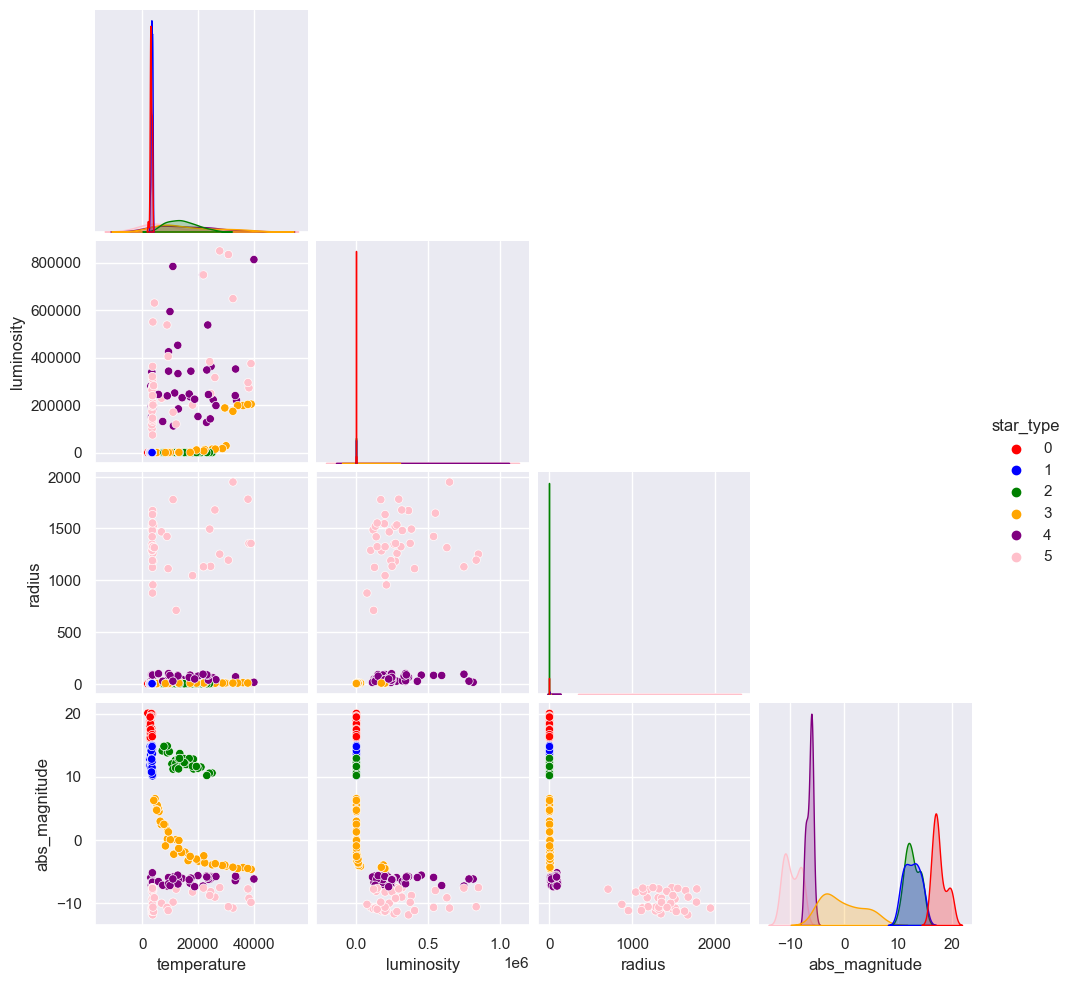

In [36]:
color_type = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'pink'
}

sns.pairplot(data, hue='star_type', corner=True, palette=color_type)

Из полученного графика можно сделать следующие выводы:
1. Целевой признак `temperature` не зависит от признаков `luminosity`, `radius`. Также не зависимости от этих признаков внутри каждого типа звезд.  
2. Можно увидеть некоторую зависимость целевого признака `temperature` от признака `abs_magnitude` внутри каждого типа звезд:
    * У типов `0`, `1`, `4` и `5` можно предположить линейную зависимость с малым коофициентом  
    * у типа `2` лучше прослеживается линейная зависимость  
    * У типа `3` прослеживается экспоненциальная зависимость 
3. Зависимости между остальными переменными не наблюдается  
4. Радиус звезды в основном зависит от ее типа

Построим графики попарных зависимостей признаков. Также расскрасим точки в зависимости от цвета звезды

c:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

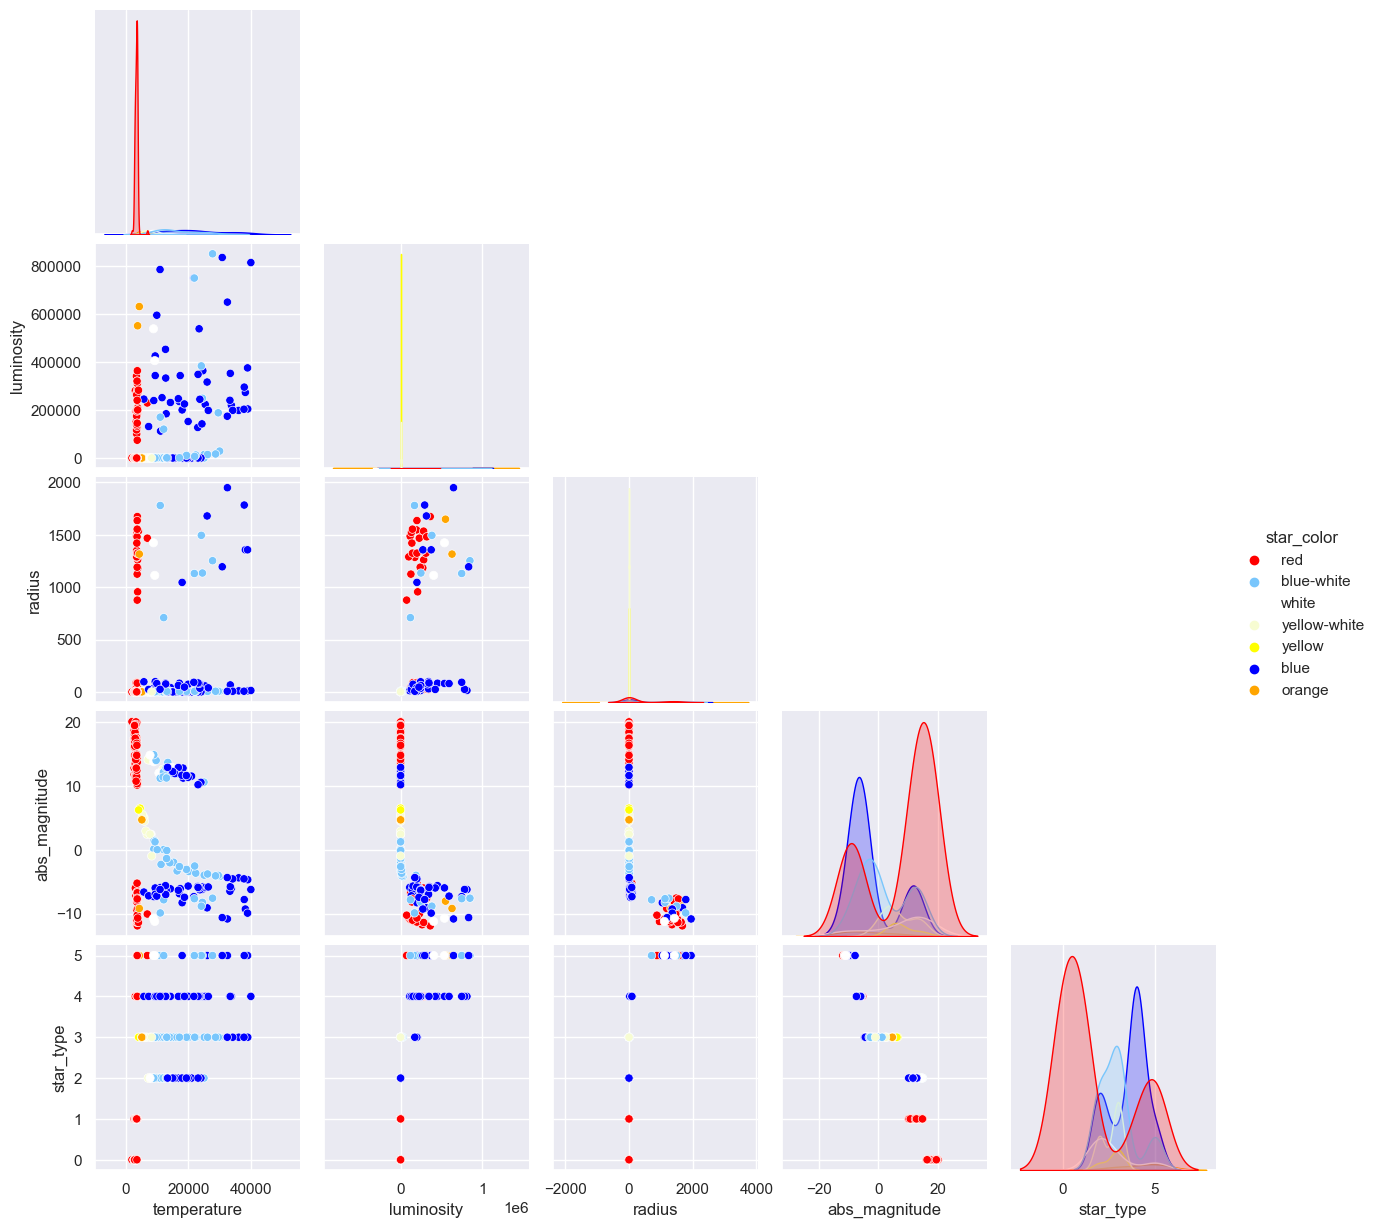

In [37]:
color_color = {
    'red': 'red',
    'blue': 'blue',
    'white': 'white',
    'yellow': 'yellow',
    'orange': 'orange',
    'blue-white': '#79c6fc',
    'yellow-white': '#f7fcd2'
}

sns.set_theme()
sns.pairplot(data, hue='star_color', corner=True, palette=color_color)

По графику зависимости температуры от типа звезды можно заметить, что звезды `0` и `1` самые холодные. Также они имеют наименьший разброс температур. Синие звезды самые горячие.

Text(0.5, 0, 'Тип звезды')

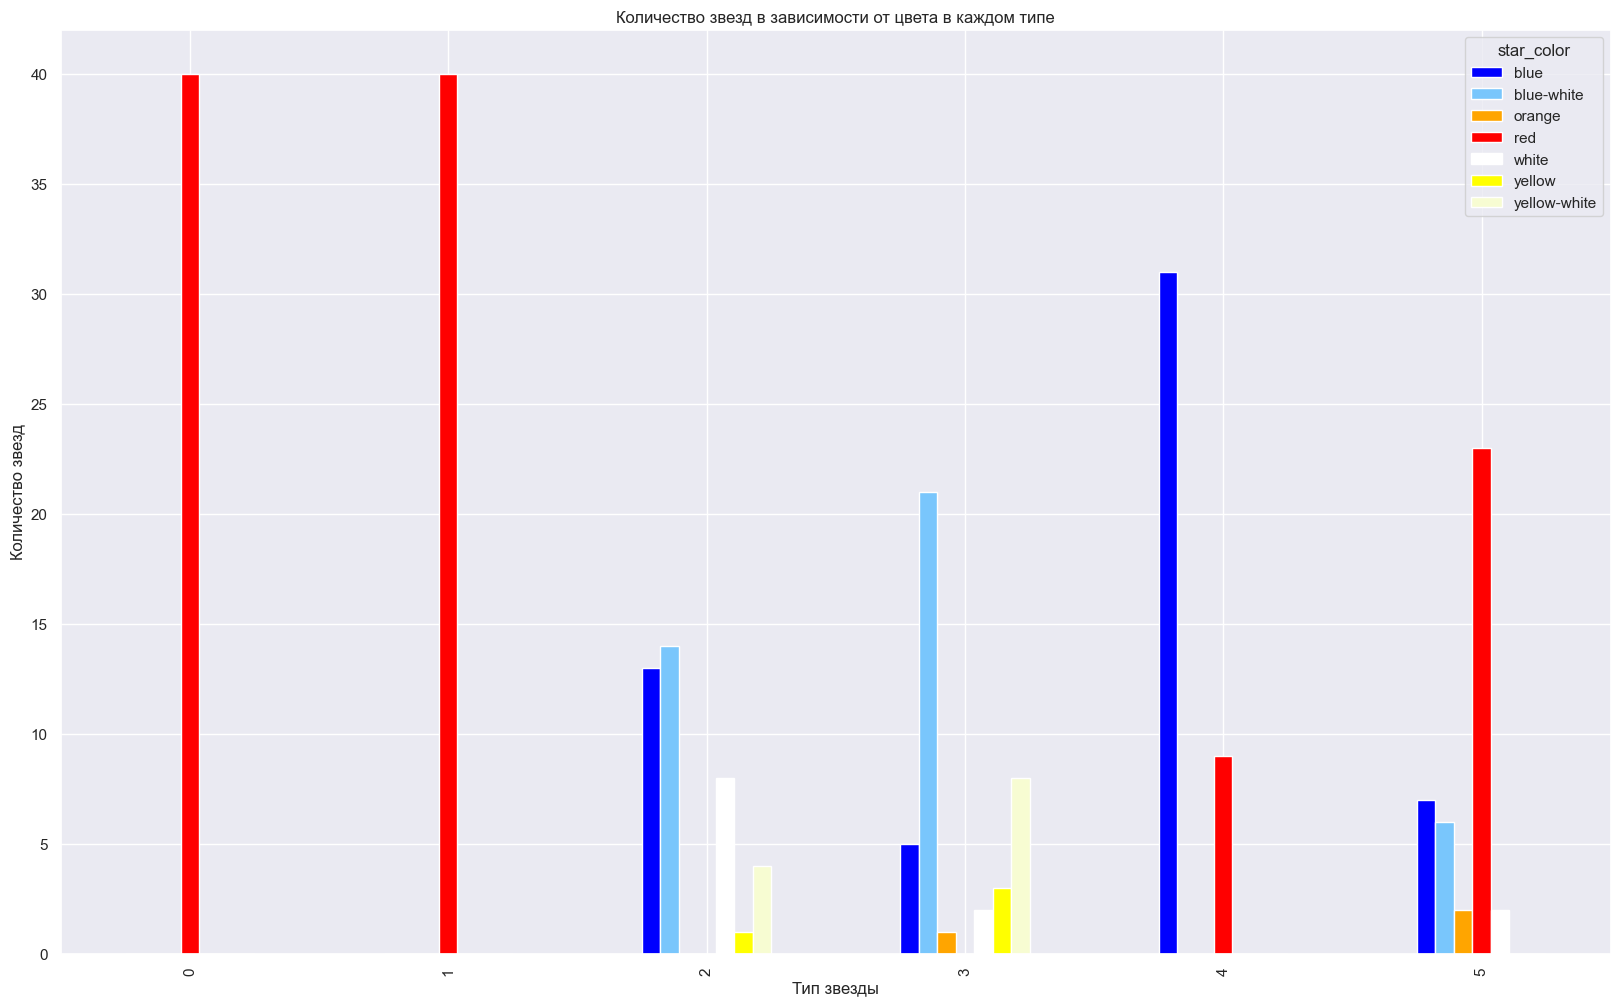

In [38]:
ax = pd.crosstab(data['star_type'], data['star_color']).plot.bar(figsize=(20, 12), color=color_color)
ax.set_title('Количество звезд в зависимости от цвета в каждом типе')
ax.set_ylabel('Количество звезд')
ax.set_xlabel('Тип звезды')

1. В категориях `0`, `1` находятся только звезды красного оттенка, что соотносится с названием категорий `Коричневый карлик` и `Красный карлик` соответственно.  
2. В категории `2` (`Белый карлик`) присутствуют звезды белого, желтого, бело-синего оттенков. Что вполне соотносится с типом звезды. Однако также присутсвуют звезды синего оттенка.  
3. В категориях `3` (`Звёзды главной последовательности`) и `5` (`Гипергигант`) присутствуют звезды всех оттенков.  
4. В категории `4` (`Сверхгигант`) присутствуют звезды синего и красного оттенков

In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(
    data.drop(['temperature'], axis=1), data['temperature'], test_size=.2,
    random_state=RANDOM_STATE, stratify=data[['star_type']]
)

In [11]:
features_train, features_test, target_test, target_valid = train_test_split(
    features_train, target_train, test_size=.25,
    random_state=RANDOM_STATE, stratify=features_train[['star_type']]
)

In [12]:
ohe_encoder = OneHotEncoder(drop='first')

In [ ]:
def ohe(df, encoder, columns):
    encoder_columns = pd.DataFrame(
        encoder.transform(df[columns]).toarray(),
        index=df.index,
        columns=encoder.get_feature_names()
    )
    df = df.join(encoder_columns)
    return df.drop(columns, axis=1)

In [ ]:
ohe_encoder.fit(features_train[['star_type', 'star_color']])

OneHotEncoder(drop='first')

In [ ]:
features_train = ohe(features_train, ohe_encoder, ['star_type', 'star_color'])
features_valid = ohe(features_valid, ohe_encoder, ['star_type', 'star_color'])
features_test = ohe(features_test, ohe_encoder, ['star_type', 'star_color'])

In [ ]:
data.head()

,temperature,luminosity,radius,abs_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,red
1,3042,0.000500,0.1542,16.60,0,red
2,2600,0.000300,0.1020,18.70,0,red
3,2800,0.000200,0.1600,16.65,0,red
4,1939,0.000138,0.1030,20.06,0,red


In [ ]:
numeric = ['luminosity', 'radius', 'abs_magnitude']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [ ]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [ ]:
features_train = torch.FloatTensor(features_train.values)
target_train = torch.FloatTensor(target_train.values)
features_valid = torch.FloatTensor(features_valid.values)
target_valid = torch.FloatTensor(target_valid.values)
features_test = torch.FloatTensor(features_test.values)
target_test = torch.FloatTensor(target_test.values)

## Построение базовой нейронной сети

In [ ]:
class StarTemperatureNet(nn.Module):
    def __init__(self, layers):
        super(StarTemperatureNet, self).__init__()
        self.layers = layers
        for i, layer in enumerate(self.layers):
            self.add_module(f'layer_{i}', layer)
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [ ]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(layer.bias, mean=.5, std=1)

In [ ]:
n_in_neurons = features_train.shape[1]
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 5
n_out_neurons = 1 

In [ ]:
net_1 = StarTemperatureNet([
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.ReLU()
])
net_1.apply(init_weights)

StarTemperatureNet(
  (layer_0): Linear(in_features=14, out_features=10, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=10, out_features=5, bias=True)
  (layer_3): ReLU()
  (layer_4): Linear(in_features=5, out_features=1, bias=True)
  (layer_5): ReLU()
)

In [ ]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net_1.parameters(), lr=1e-3)

In [ ]:
train_endpoint = []
valid_endpoint = []

In [ ]:
for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    preds = net_1(features_train)
    loss_value = loss(preds, target_train)
    loss_value.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0 or epoch + 1 == NUM_EPOCHS:
        train_endpoint.append(loss_value.item())
        print (f'Эпоха [{epoch+1}/{NUM_EPOCHS}]. Значение функции потерь: {loss_value.item():.4f}')
        net_1.eval()
        valid_preds = net_1(features_valid)
        loss_valid = loss(valid_preds, target_valid)
        valid_endpoint.append(loss_valid.item())
        print(f'Значение функции потерь: {loss_valid.item():.4f}')

/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([192])) that is different to the input size (torch.Size([144, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Эпоха [100/2000]. Значение функции потерь: 121684728.0000
Значение функции потерь: 122163968.0000


/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Эпоха [200/2000]. Значение функции потерь: 116665992.0000
Значение функции потерь: 117108256.0000
Эпоха [300/2000]. Значение функции потерь: 111870024.0000
Значение функции потерь: 112291080.0000
Эпоха [400/2000]. Значение функции потерь: 107360768.0000
Значение функции потерь: 107776528.0000
Эпоха [500/2000]. Значение функции потерь: 103193352.0000
Значение функции потерь: 103616896.0000
Эпоха [600/2000]. Значение функции потерь: 99411824.0000
Значение функции потерь: 99854496.0000
Эпоха [700/2000]. Значение функции потерь: 96047320.0000
Значение функции потерь: 96523568.0000
Эпоха [800/2000]. Значение функции потерь: 93113632.0000
Значение функции потерь: 93640784.0000
Эпоха [900/2000]. Значение функции потерь: 90616464.0000
Значение функции потерь: 91201120.0000
Эпоха [1000/2000]. Значение функции потерь: 88539256.0000
Значение функции потерь: 89179712.0000
Эпоха [1100/2000]. Значение функции потерь: 86858896.0000
Значение функции потерь: 87565472.0000
Эпоха [1200/2000]. Значение фу

In [ ]:
x = range(100, NUM_EPOCHS+1, 100)
for i in x:
    print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [ ]:
import numpy as np

In [ ]:
a = np.linspace(1, 10, 5)
a

array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ])

In [ ]:
b = np.linspace(11, 30, 10)
b

array([11.        , 13.11111111, 15.22222222, 17.33333333, 19.44444444,
       21.55555556, 23.66666667, 25.77777778, 27.88888889, 30.        ])

In [ ]:
np.meshgrid(a, b)

[array([[ 1.  ,  3.25,  5.5 ,  7.75, 10.  ],
        [ 1.  ,  3.25,  5.5 ,  7.75, 10.  ],
        [ 1.  ,  3.25,  5.5 ,  7.75, 10.  ],
        [ 1.  ,  3.25,  5.5 ,  7.75, 10.  ],
        [ 1.  ,  3.25,  5.5 ,  7.75, 10.  ],
        [ 1.  ,  3.25,  5.5 ,  7.75, 10.  ],
        [ 1.  ,  3.25,  5.5 ,  7.75, 10.  ],
        [ 1.  ,  3.25,  5.5 ,  7.75, 10.  ],
        [ 1.  ,  3.25,  5.5 ,  7.75, 10.  ],
        [ 1.  ,  3.25,  5.5 ,  7.75, 10.  ]]),
 array([[11.        , 11.        , 11.        , 11.        , 11.        ],
        [13.11111111, 13.11111111, 13.11111111, 13.11111111, 13.11111111],
        [15.22222222, 15.22222222, 15.22222222, 15.22222222, 15.22222222],
        [17.33333333, 17.33333333, 17.33333333, 17.33333333, 17.33333333],
        [19.44444444, 19.44444444, 19.44444444, 19.44444444, 19.44444444],
        [21.55555556, 21.55555556, 21.55555556, 21.55555556, 21.55555556],
        [23.66666667, 23.66666667, 23.66666667, 23.66666667, 23.66666667],
        [25.77777778, 2

## Улучшение нейронной сети

## Выводы